<a href="https://colab.research.google.com/github/alejandro-ao/tbs-msc-projects/blob/master/Sentiment_Analysis_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash  

In [ ]:
import sparknlp

In [ ]:
# stop previous spark session
if 'spark' in locals() or 'spark' in globals():
    spark.stop()
# open new spark session for NLP
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 4.2.6
Apache Spark version: 3.2.3


In [40]:
# mount your google drive to be able to access files from your google drive ! 
from google.colab import drive
drive.mount('/content/drive')

file_path = "drive/MyDrive/PYSPARK-COURSE/Project/trump_tweets.txt"
tweets = spark.read.text(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# we need to get just text 
tweets.head()

Row(value='Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48')

In [50]:
# split the text and number using the ";" delimiter
from pyspark.sql.functions import split, col

tweets = tweets.withColumn("split", split(col("value"), ";"))

# get only the text into a new column titled 'text'
tweets = tweets.select(col("split").getItem(0).alias("text"))

In [30]:
from sparknlp.pretrained import PretrainedPipeline 
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

# create pipeline

document = DocumentAssembler() \
.setInputCol("text") \
.setOutputCol("document")

token = Tokenizer() \
.setInputCols(["document"]) \
.setOutputCol("token")

normalizer = Normalizer() \
.setInputCols(["token"]) \
.setOutputCol("normal")

vivekn =  ViveknSentimentModel.pretrained() \
.setInputCols(["document", "normal"]) \
.setOutputCol("result_sentiment")

finisher = Finisher() \
.setInputCols(["result_sentiment"]) \
.setOutputCols("final_sentiment")

pipeline = Pipeline().setStages([document, token, normalizer, vivekn, finisher])


sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]


In [53]:
# train the model
pipeline_model = pipeline.fit(tweets)

In [54]:
# get sentiment
result = pipeline_model.transform(tweets)

In [60]:
result.head()

Row(text='Republicans and Democrats have both created our economic problems.', final_sentiment=['positive'])

In [68]:
from pyspark.sql.functions import count

counts = result.groupBy("final_sentiment").agg(count("*").alias("count"))

In [105]:
counts = counts.withColumn("final_sentiment", col("final_sentiment")[0])

In [107]:
# convert to pandas df

counts_df = counts.toPandas()

In [108]:
counts_df.head()

,final_sentiment,count
0,positive,25765
1,None,1308
2,negative,28443
3,na,3165


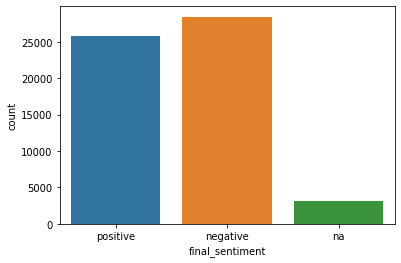

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="final_sentiment", y="count", data=counts_df)

In [133]:
counts_df['percentage'] = counts_df['count'] / counts_df['count'].sum()
counts_df.head()

,final_sentiment,count,percentage
0,positive,25765,0.439069
1,None,1308,0.022290
2,negative,28443,0.484705
3,na,3165,0.053936


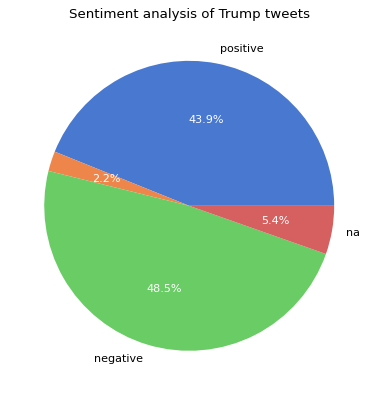

In [143]:
# extract the values for the pie chart
values = counts_df['percentage'].values
labels = counts_df['final_sentiment'].values

# create the pie chart
colors = sns.color_palette('muted')[0:4]
plt.figure(figsize=(8, 6), dpi=80)
_, _, autotexts = plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Sentiment analysis of Trump tweets")

for ins in autotexts:
    ins.set_color('white')

plt.show()